# FlexDamage: Step-by-Step Tutorial

This notebook provides a granular, step-by-step guide to using the `flexdamage` library components individually. Instead of running the black-box `EstimationPipeline.run()`, we will manually orchestrate each stage of the process. This is useful for debugging, research, and understanding the internal data flow.

## Workflow Steps
1. **Mock Data Generation**: Create synthetic data (including GDP transformations).
2. **Setup**: Initialize configuration and logging.
3. **Data Loading & Preprocessing**: Load data, transform (scale), and aggregate (e.g., over GCMs).
4. **Global Estimation**: Estimate the global Gamma parameter (Income Elasticity).
5. **Regional Estimation**: Estimate regional response curves (with Convexity Constraints).
6. **Diagnostics**: Generate plots.
7. **F2 Tables**: Generate projection tables.

In [2]:
import sys
import shutil
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ensure package is discoverable
project_root = Path("../").resolve()
sys.path.append(str(project_root))

from flexdamage.config.loader import load_config
from flexdamage.core.pipeline import EstimationPipeline
from flexdamage.core.global_est import GlobalEstimator
from flexdamage.core.regional import RegionalEstimator
from flexdamage.data.backends import PandasBackend
from flexdamage.data.preprocessing import DataPreprocessor
from flexdamage.core.f2_gen import F2Generator
from flexdamage.utils.logging import setup_logging
from flexdamage.diagnostics.plots import plot_gamma_distribution, plot_parameter_distributions, plot_prediction_curves, plot_damages_by_scenario

# Setup output directory
base_dir = Path("step_by_step_output")
if base_dir.exists():
    shutil.rmtree(base_dir)
base_dir.mkdir()
data_dir = base_dir / "data"
data_dir.mkdir()
results_dir = base_dir / "results"
results_dir.mkdir()
diag_dir = results_dir / "diagnostics"
diag_dir.mkdir()
f2_dir = results_dir / "f2"
f2_dir.mkdir()

setup_logging(level="INFO")

2026-01-14 13:52:10 | INFO     | flexdamage | Logging initialized (Level: INFO)


## 1. Mock Data Generation
Generating random mortality data with a U-shaped temperature response. 
Crucially, we also include **GDP** variables and calculate transformations (`loggdppc`, `lgdp_delta`) as required for the Mortality Global Estimation (where Gamma represents Income Elasticity).

In [3]:
print("Generating Mock Data...")
n = 3000
np.random.seed(42)

# Basic variables
df = pd.DataFrame({
    "iso3": np.random.choice([f"ISO_{i}" for i in range(20)], n),
    "year": np.random.randint(2000, 2021, n),
    "gcm": np.random.choice(["ModelA", "ModelB", "ModelC"], n),
    "rcp": np.random.choice(["rcp45", "rcp85"], n),
    "ssp": np.random.choice(["ssp2", "ssp3", "ssp4", "ssp5"], n),
    "temperature_anomaly": np.random.uniform(-3, 6, n),
    "pop": np.random.uniform(1e5, 5e6, n),
    "gdppc": np.exp(np.random.normal(9.5, 0.4, n)) # Log-normal GDP
})

# --- 1. GDP Transformations (mimicking alpha-fit-mortality.R) ---
df["loggdppc"] = np.log(df["gdppc"])

# Calculate baseline reference GDP (e.g., mean 2010-2015) for calculation of delta
# For simplicity in this mock, we'll just take the mean per region/ssp/rcp
gdp_ref = df[df.year.between(2010, 2015)].groupby(["iso3", "ssp", "rcp"])["loggdppc"].mean().reset_index()
gdp_ref.rename(columns={"loggdppc": "avg_gdp_ref"}, inplace=True)

df = df.merge(gdp_ref, on=["iso3", "ssp", "rcp"], how="left")
# Fill missing refs (random years might not cover 2010-2015 for all groups in this small sample)
df["avg_gdp_ref"] = df.groupby("iso3")["loggdppc"].transform("mean")

df["lgdp_delta"] = df["loggdppc"] - df["avg_gdp_ref"]

# --- 2. Impact Logic ---
# True parameters
true_alpha = -0.05
true_beta = 0.03 # Positive beta -> Convex U-shape
true_gamma = -0.005 # Income elasticity (small negative effect)

# Impact = (alpha*T + beta*T^2) * (GDP_Factor) + noise
# Or simpler for FE estimation: y ~ gamma * lgdp_delta + FE...
# Let's mock it such that 'lgdp_delta' actually matters.
df["mortality_impact"] = (
    true_alpha * df["temperature_anomaly"] + 
    true_beta * df["temperature_anomaly"]**2 + 
    true_gamma * df["lgdp_delta"] +  # Income effect
    np.random.normal(0, 0.1, n)
)

csv_path = data_dir / "mock_mortality.csv"
df.to_csv(csv_path, index=False)
print(f"Saved {len(df)} records to {csv_path}")
df.head()

Generating Mock Data...
Saved 3000 records to step_by_step_output/data/mock_mortality.csv


,iso3,year,gcm,rcp,ssp,temperature_anomaly,pop,gdppc,loggdppc,avg_gdp_ref,lgdp_delta,mortality_impact
0,ISO_6,2012,ModelC,rcp45,ssp5,5.327382,8.386113e+05,11751.664974,9.371750,9.519577,-0.147827,0.602738
1,ISO_19,2015,ModelC,rcp45,ssp3,-1.677931,3.140740e+06,10477.565550,9.256992,9.456692,-0.199701,0.091780
2,ISO_14,2003,ModelC,rcp45,ssp4,5.737688,2.157361e+06,10032.781000,9.213613,9.500497,-0.286884,0.744279
3,ISO_10,2004,ModelB,rcp85,ssp4,5.527295,3.105088e+06,13822.021278,9.534018,9.531724,0.002294,0.638559
4,ISO_7,2004,ModelC,rcp85,ssp3,4.961148,3.832207e+06,12139.476752,9.404218,9.505645,-0.101427,0.475333


## 2. Configuration Setup

In [4]:
config_dict = {
    "run": {
        "name": "step_by_step_run",
        "output_dir": str(results_dir)
    },
    "sector": {
        "name": "mortality"
    },
    "data": {
        "dataset_dir": str(data_dir),
        "source_format": "csv",
        "columns": {
            "y": "mortality_impact",
            "x1": "temperature_anomaly", # For Regional Estimation (Response to Temp)
            "x": "lgdp_delta", # For Global Estimation (Gamma = Coeff on Income)
            "w": "pop",
            "region": "iso3"
        },
        "aggregation": {
            "dims": ["iso3", "year"],
            "method": "mean",
            "weights": "pop"
        }
    },
    "estimation": {
        "functional_form": {
            "type": "explicit",
            "formula": "alpha * x + beta * x**2"
        },
        "global": {
            "method": "fixed_effects",
            "temperature_bins": 5
        },
        "regional": {
            "aggregation_level": "country",
            "backend": "pandas",
            "min_observations": 10
        },
        "constraints": [
            {
                "type": "convexity",
                "parameter": "beta" 
            }
        ]
    },
    "execution": {
        "test_mode": False
    }
}

config_path = base_dir / "config.yaml"
with open(config_path, "w") as f:
    yaml.dump(config_dict, f)

config = load_config(config_path)
print("Config loaded.")

Config loaded.


## 3. Data Loading & Preprocessing

Here we manually initialize the backend and preprocessor. Note that we are **aggregating over GCMs** here.

In [5]:
# Initialize Backend
backend = PandasBackend.from_csv(str(csv_path))

# Load Data (getting all columns needed)
required_cols = list(config.data.columns.values()) + ["gcm", "year", "iso3", "rcp", "ssp"]
print(f"Requested cols: {required_cols}")

df_raw = backend.load_data(
    columns=required_cols
)
print(f"Raw Data Shape: {df_raw.shape}")

# Preprocess (Aggregation & Transformation)
preprocessor = DataPreprocessor(config.data)
df_proc = preprocessor.process(df_raw)
print(f"Processed Data Shape (Aggregated): {df_proc.shape}")
df_proc.head()

2026-01-14 13:52:14 | INFO     | flexdamage.data.backends | Loading CSV from step_by_step_output/data/mock_mortality.csv
Requested cols: ['iso3', 'pop', 'lgdp_delta', 'temperature_anomaly', 'mortality_impact', 'gcm', 'year', 'iso3', 'rcp', 'ssp']
Raw Data Shape: (3000, 9)
2026-01-14 13:52:14 | INFO     | flexdamage.data.preprocessing | Aggregating data by ['iso3', 'year'] using mean
Processed Data Shape (Aggregated): (419, 6)


/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/data/preprocessing.py:103: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_term = df.groupby(group_cols).apply(lambda x: (x[c] * x[w_col]).sum())
/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/data/preprocessing.py:103: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

,iso3,year,pop,lgdp_delta,temperature_anomaly,mortality_impact
0,ISO_0,2000,2.301085e+07,0.122291,2.658355,0.343867
1,ISO_0,2001,2.815892e+07,0.109478,1.497958,0.162664
2,ISO_0,2002,1.698307e+06,0.507707,1.422142,0.033478
3,ISO_0,2003,1.184692e+07,0.108451,2.651400,0.200269
4,ISO_0,2004,4.179238e+06,0.021329,3.546056,0.377272


## 4. Global Estimation

Estimate Gamma (Income Elasticity) using Fixed Effects.

In [6]:
global_est = GlobalEstimator(config)
global_results = global_est.estimate(df_proc)

gamma = global_results.get("gamma")
print(f"Estimated Gamma: {gamma:.4f}")

2026-01-14 13:52:15 | INFO     | flexdamage.core.global_est | Starting Global Estimation (Method: fixed_effects)
2026-01-14 13:52:15 | INFO     | flexdamage.core.global_est | Estimated Gamma: 0.044842 (SE: 0.003833)
Estimated Gamma: 0.0448


/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/core/global_est.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma = mod.params[1]
/project/cil/home_dirs/scadavidsanchez/projects/ag-flex-damage-functions/flexdamage-dev/flexdamage/core/global_est.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gamma_se = mod.bse[1]


## 5. Regional Estimation

Iterate through regions and fit the polynomial curves given the global Gamma.

In [7]:
reg_est = RegionalEstimator(config, gamma=gamma)
regions = df_proc["iso3"].unique()
print(f"Estimating for {len(regions)} regions...")

regional_results = []
reg_col = config.data.columns.get("region", "region")

for region in regions:
    df_reg = df_proc[df_proc[reg_col] == region]
    res = reg_est.estimate_region(region, df_reg)
    if res:
        regional_results.append(res)

df_results = pd.DataFrame(regional_results)
print(f"Estimated parameters for {len(df_results)} regions.")
df_results.head()

Estimating for 20 regions...
Estimated parameters for 20 regions.


,region,n_obs,rsqr,alpha,beta
0,ISO_0,21,-1.408713,-0.055813,0.252521
1,ISO_1,21,-1.153241,-0.121592,1.027054
2,ISO_10,21,-3.688709,0.173567,1.759439
3,ISO_11,21,-0.767999,-0.125616,2.001027
4,ISO_12,21,-0.947060,-0.253984,4.684752


## 6. Diagnostics

Generate and display diagnostic plots. 
Includes distribution of regional parameters.

2026-01-14 13:52:19 | INFO     | flexdamage.diagnostics.plots | Saved Gamma plot to step_by_step_output/results/diagnostics/gamma_distribution.png


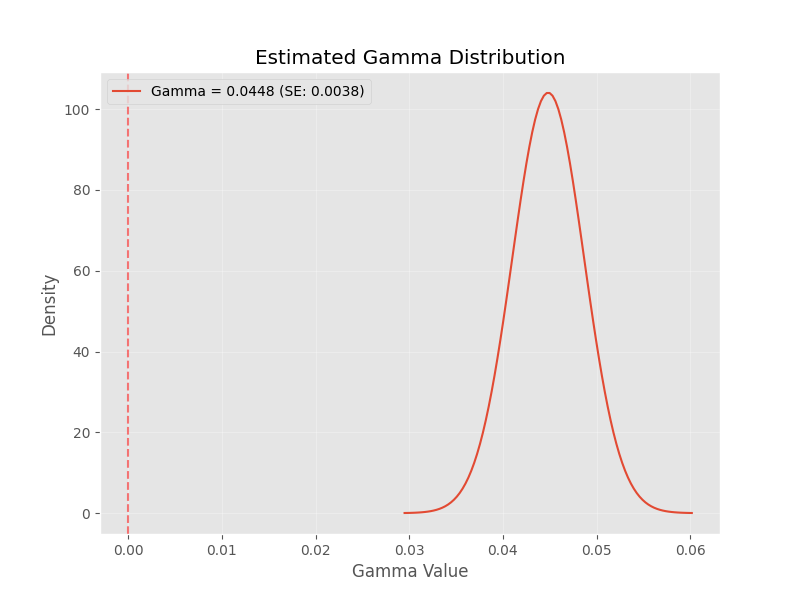

2026-01-14 13:52:20 | INFO     | flexdamage.diagnostics.plots | Saved parameter distributions to step_by_step_output/results/diagnostics/parameter_distributions.png


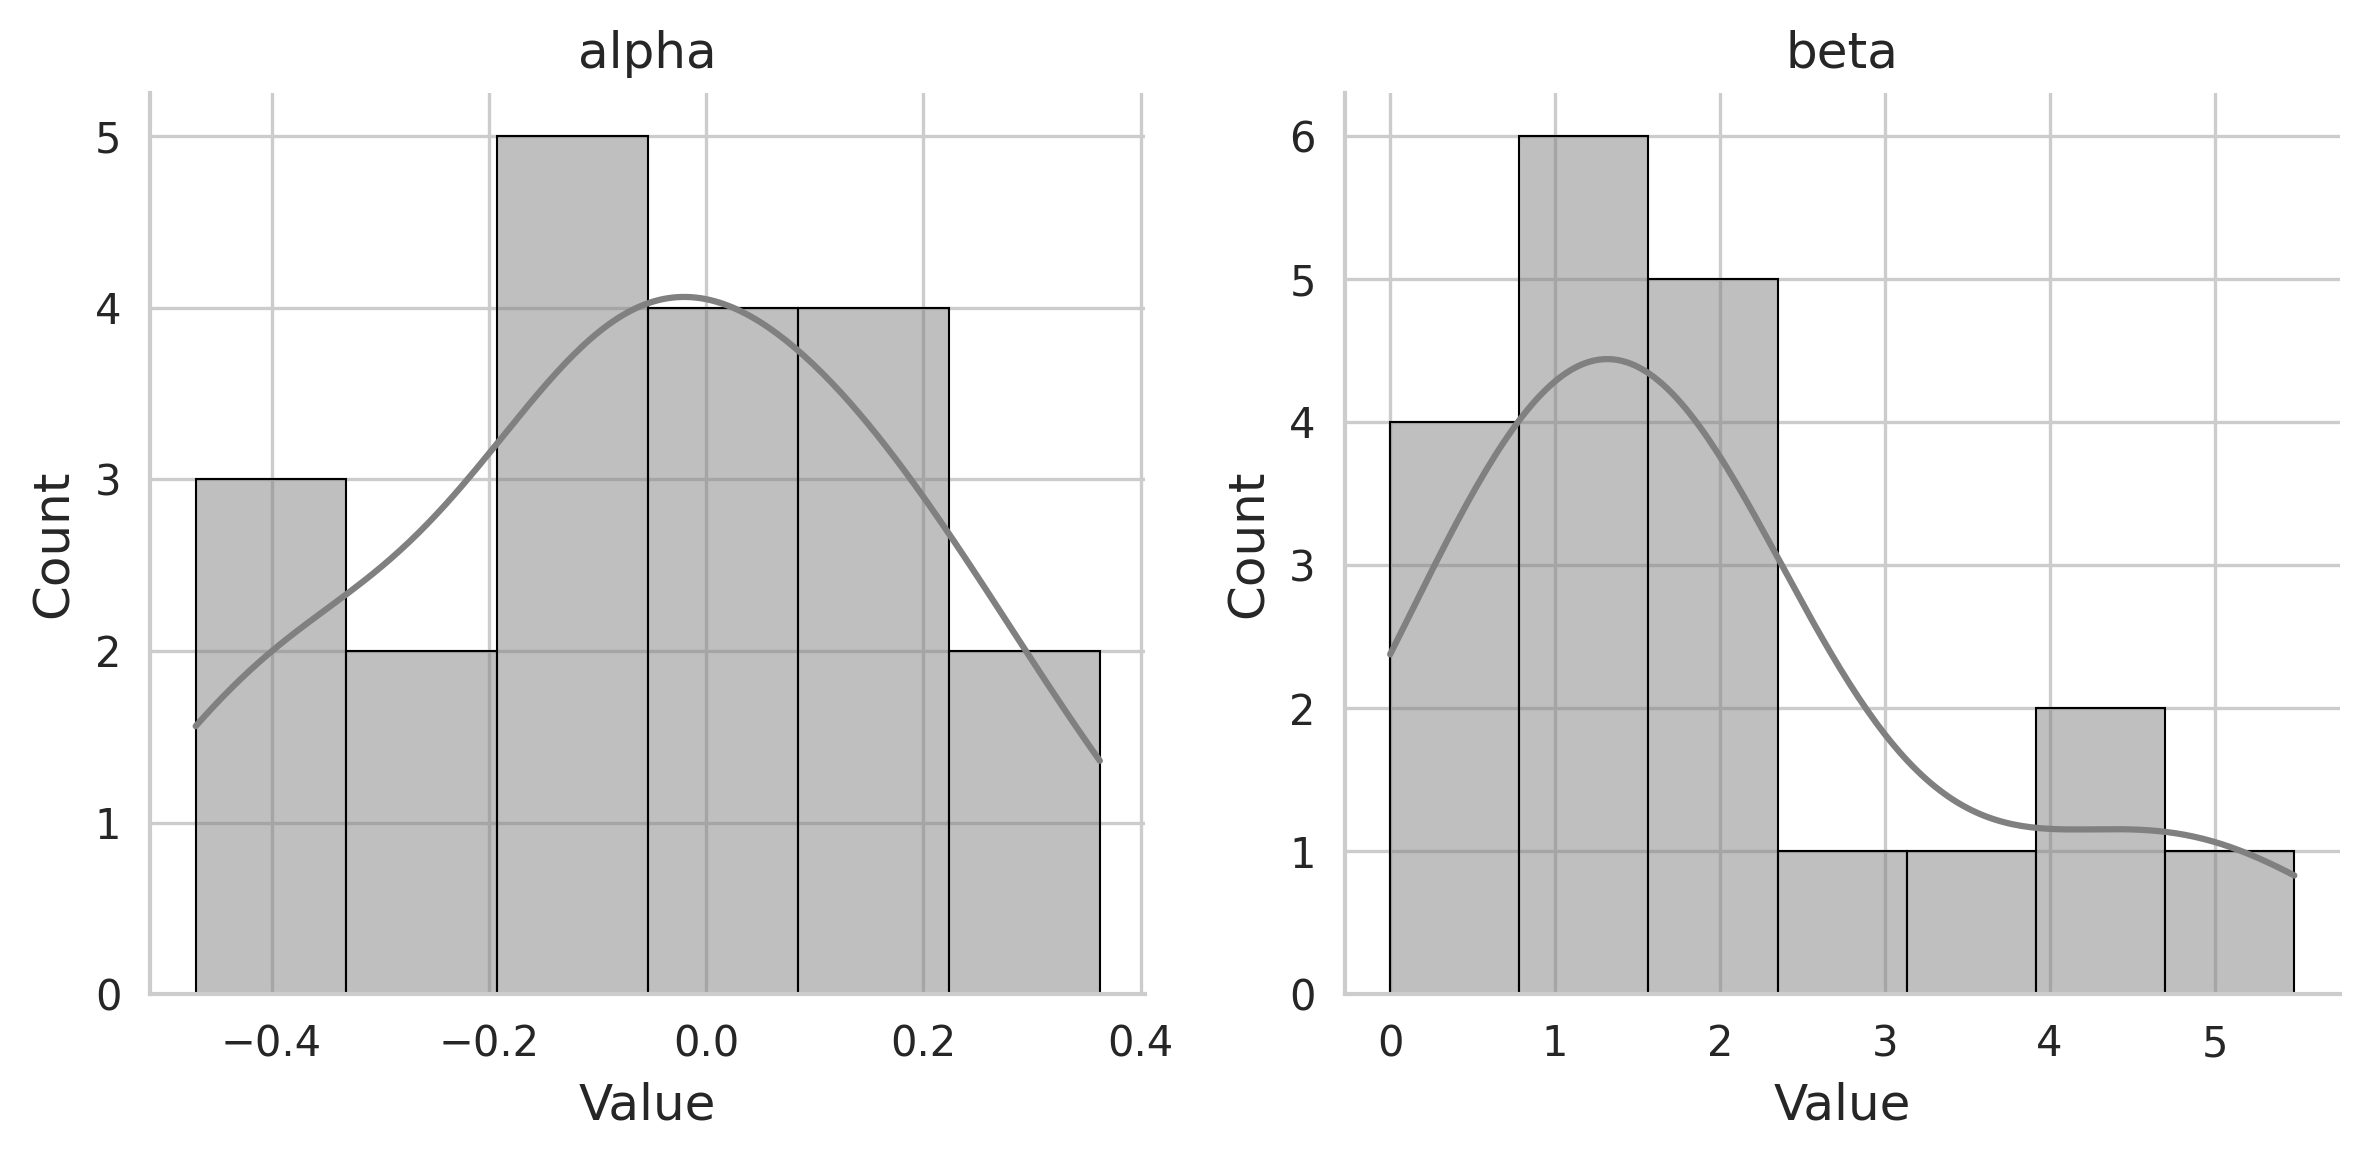

2026-01-14 13:52:20 | INFO     | flexdamage.diagnostics.plots | Saved regional curves plot to step_by_step_output/results/diagnostics/regional_curves.png


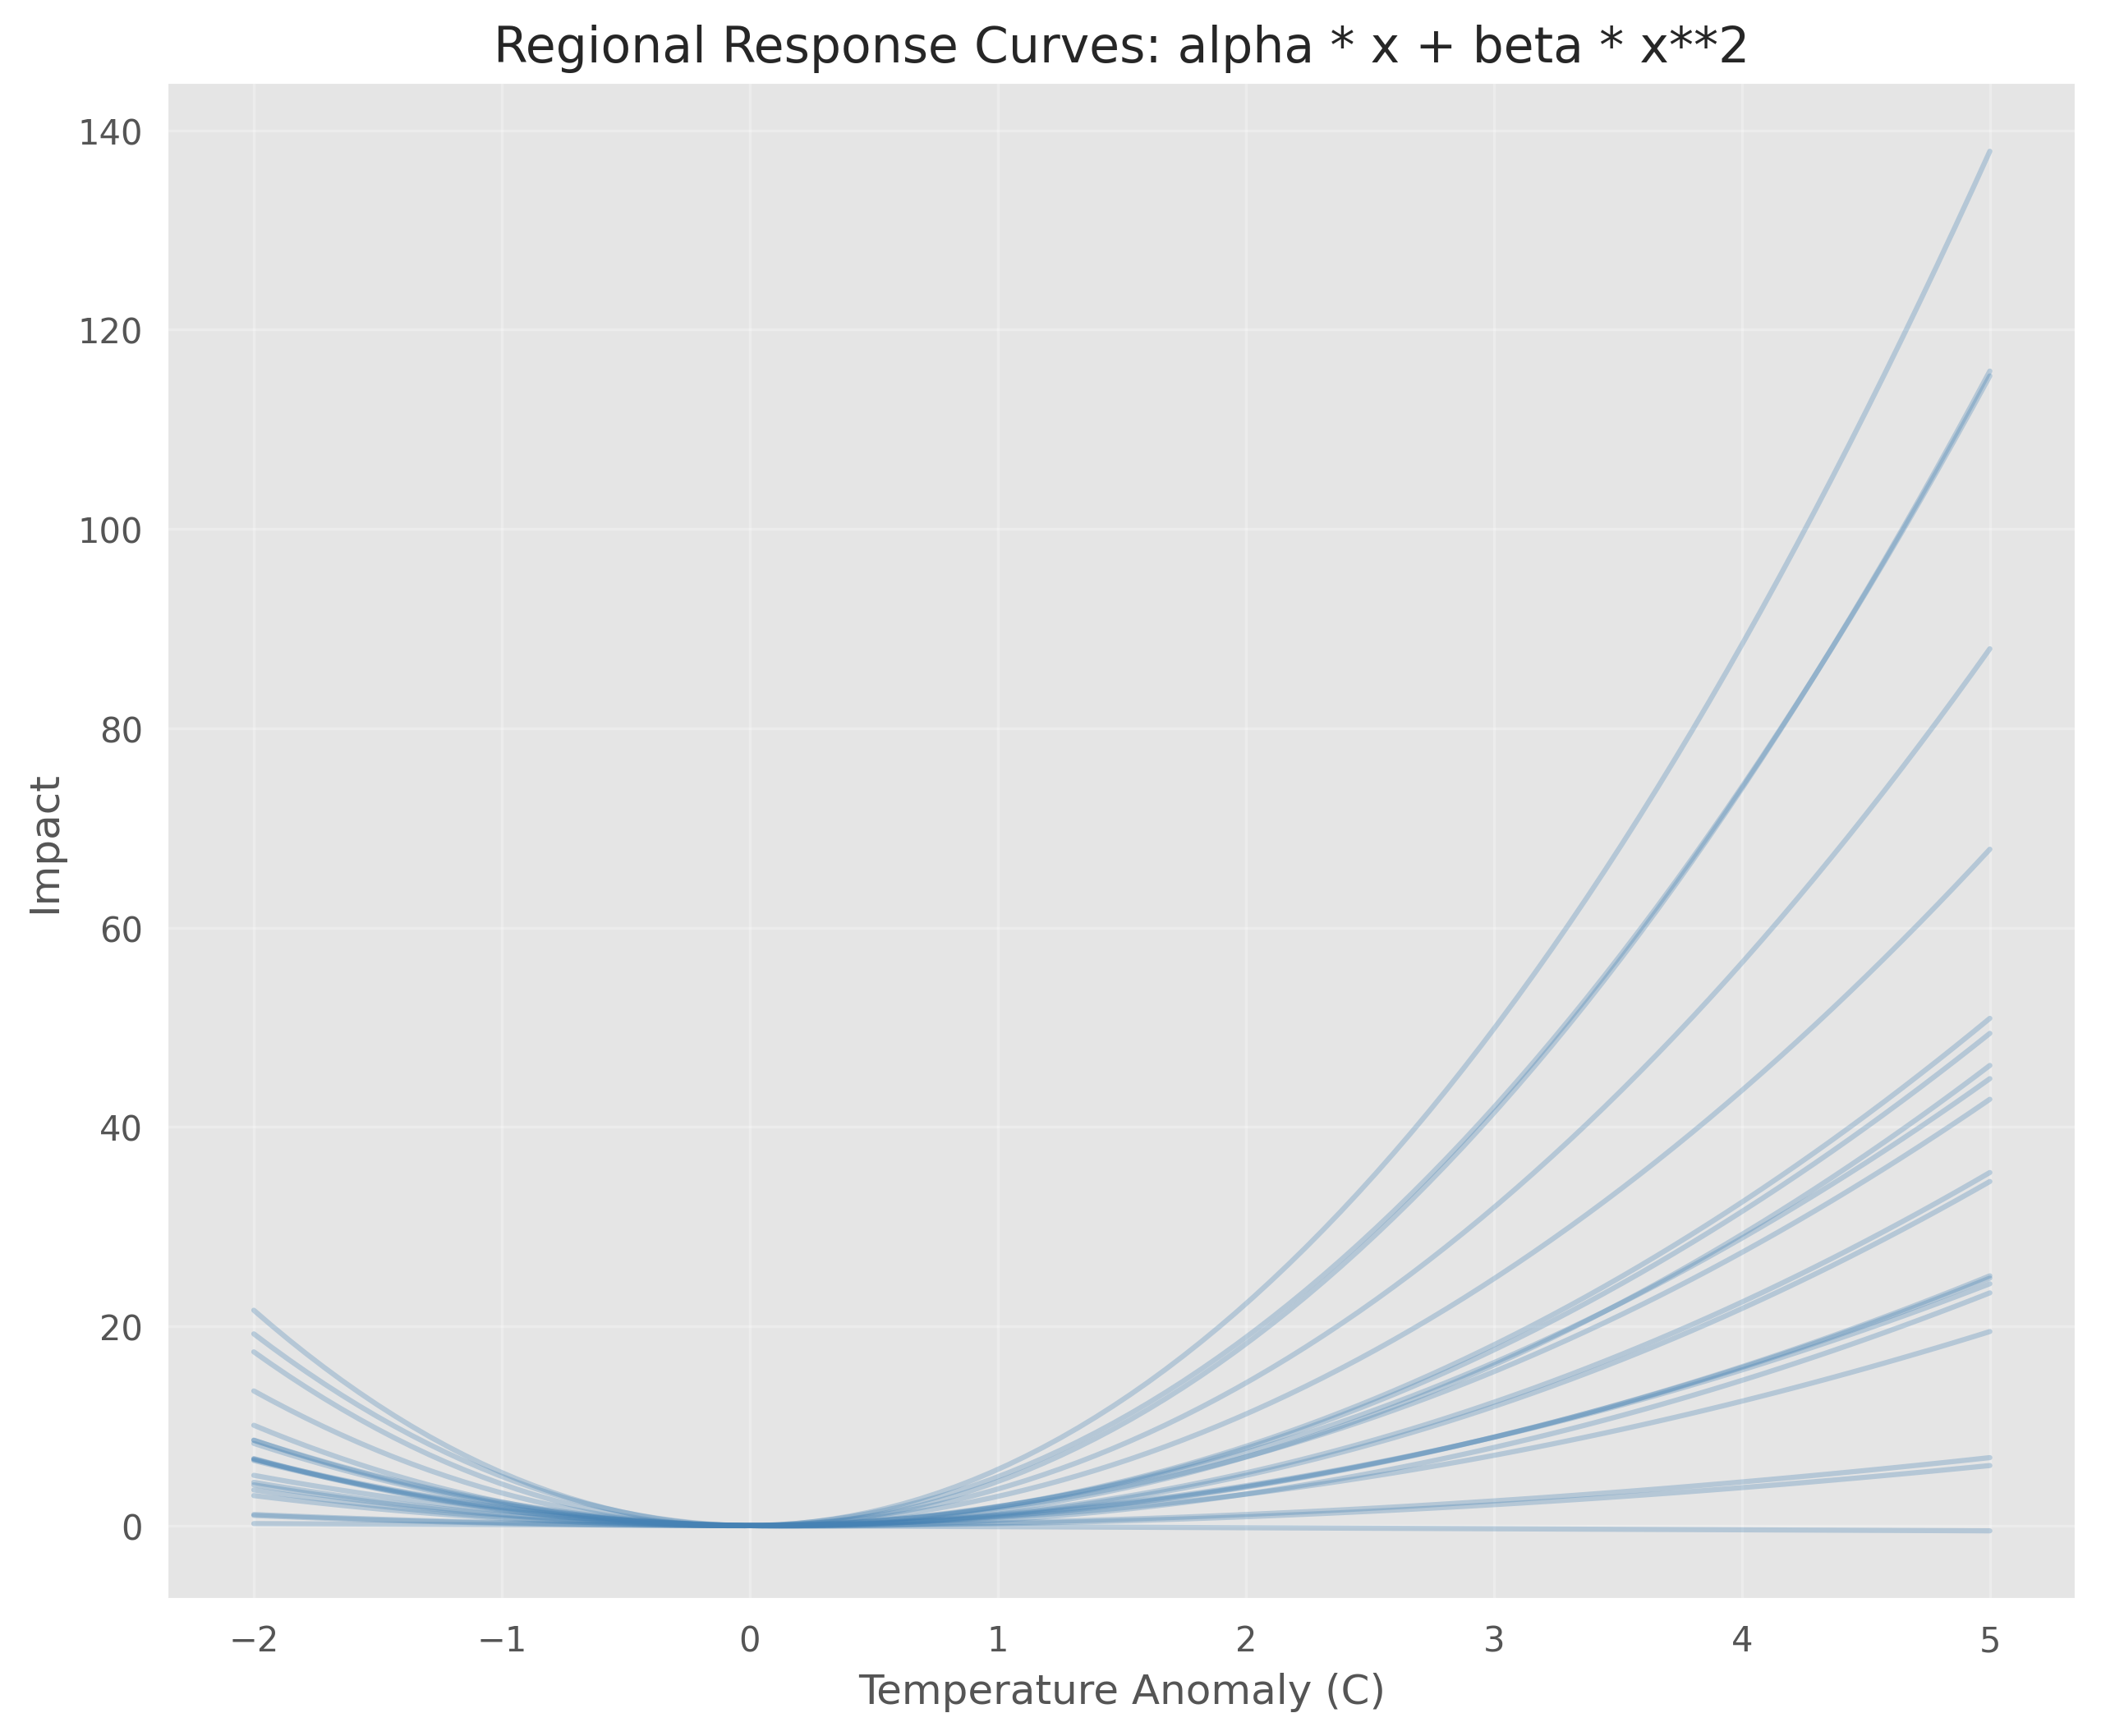

In [8]:
from IPython.display import Image, display

# Gamma Distribution
plot_gamma_distribution(global_results, diag_dir)
display(Image(filename=diag_dir / "gamma_distribution.png"))

# Parameter Distributions (FacetGrid)
plot_parameter_distributions(df_results, diag_dir)
display(Image(filename=diag_dir / "parameter_distributions.png"))

# Prediction Curves (subset of regions)
plot_prediction_curves(df_results, config.estimation.functional_form.formula, diag_dir)
display(Image(filename=diag_dir / "regional_curves.png"))

## 7. F2 Generation & Analysis

Generate projected damage tables (`flexraw`, `rawtotal`) and visualize them by SSP/RCP.

In [9]:
f2_gen = F2Generator(config, df_results)
f2_gen.generate(df_proc, f2_dir)

f2_df = pd.read_csv(f2_dir / "f2_projections.csv")
print("Projected Damages:")
print(f2_df.head())

# Plot Damages by Scenario
if "ssp" in f2_df.columns and "rcp" in f2_df.columns:
    plot_damages_by_scenario(f2_df, diag_dir)
    display(Image(filename=diag_dir / "damages_by_scenario.png"))
else:
    print("Mock data did not preserve scenario columns for this plot.")

2026-01-14 13:52:29 | INFO     | flexdamage.core.f2_gen | Generating F2 Tables (Projections)...
2026-01-14 13:52:29 | INFO     | flexdamage.core.f2_gen | Saved F2 table to step_by_step_output/results/f2/f2_projections.csv
Projected Damages:
    iso3  year           pop  lgdp_delta  temperature_anomaly  \
0  ISO_0  2000  2.301085e+07    0.122291             2.658355   
1  ISO_0  2001  2.815892e+07    0.109478             1.497958   
2  ISO_0  2002  1.698307e+06    0.507707             1.422142   
3  ISO_0  2003  1.184692e+07    0.108451             2.651400   
4  ISO_0  2004  4.179238e+06    0.021329             3.546056   

   mortality_impact   _grp  _mortality_impact_demean  \
0          0.343867  ISO_0                  0.148859   
1          0.162664  ISO_0                 -0.029909   
2          0.033478  ISO_0                 -0.168071   
3          0.200269  ISO_0                 -0.037177   
4          0.377272  ISO_0                  0.147916   

   _temperature_anomaly_demean 